# HOMEWORK 2 - TRANSFER FUNCTIONS AND SYSTEM IDENTIFICATION

This homework is about transfer functions and system identification.
There are two problems.

Make a copy of this notebook, and answer the questions.

# Preliminaries

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy
import tellurium as te
import sympy

# Helpers

In [2]:
class PlotResult(object):

    def __init__(self, times=None, yt=None, ax=None):
        self.times = times
        self.yt = yt
        self.ax = ax
        
    def __repr__(self):
        return ""

In [3]:
def plotTF(tf, times=None, is_plot=True, figsize=(5,5)):
    if times is None:
        times = np.linspace(0, 10, 100)
    _, yt = control.forced_response(tf, T=times, U=1)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.plot(times, yt)
        ax.set_xlabel("time")
    else:
        ax = None
    return PlotResult(times=times, yt=yt, ax=ax)

# Tests
tf = control.TransferFunction([1], [1, 0])
plot_result = plotTF(tf, is_plot=False)
assert(isinstance(plot_result, PlotResult))
print("OK!")

OK!


# Problem 1: Constructing Laplace Transforms for reaction networks

In this problem, you will construct a Laplace transform
for the same branching network we discussed in class, but with
a different input and output.
Below is the reaction network:

\begin{eqnarray}
s_1 & \xrightarrow{k_1 s_1} s_2 \\
s_2 & \xrightarrow{k_2 s_2} s_1 \\
s_1 & \xrightarrow{k_3 s_1} s_3 \\
u & \xrightarrow{k_1 u} s_2 \\
\end{eqnarray}

The input to the system is $u$; the output is $s_2$. (In class, the output
was $s_3$.)

## 1. (5 pts) System equations

$\dot s_{1} = -k_{1}s_{1} + k_{2}s_{2} - k_{3}s_{1}$ <br>
$\dot s_{2} = k_{1}s_{1} - k_{2}s_{2} + k_{1}u$ <br>
$\dot s_{3} = k_{3}s_{1}$

## 2. (5 pts) LT of system equations

$sS_{1}(s) = -k_{1}S_{1}(s) + k_{2}S_{2}(s) - k_{3}S_{1}(s)$ <br>
$sS_{2}(s) = k_{1}S_{1}(s) - k_{2}S_{2}(s) + k_{1}U(s)$ <br>
$sS_{3}(s) = k_{3}S_{1}(s)$

## 3. (25 pts) Calculate transfer function

$G(s) = \frac{S_{3}(s)}{S_{2}(s)} = \frac{k_{3}k_{2}}{s(s+k_{1}+k_{3})} = \frac{k_{3}k_{2}}{s^{2}+s(k_{1}+k_{3})}$

**Comment**
1. The answer is correct. Did you solve it by hand? Below is how you can do this with ``sympy``.

In [4]:
s, S_1, S_2, S_3, k_1, k_2, k_3, U = sympy.symbols("s, S_1, S_2, S_3, k_1, k_2, k_3, U")

In [19]:
expr1 = s*S_1 + k_1*S_1 - k_2*S_2 + k_3*S_1
sub_S_1 = sympy.solve(expr1, S_1)[0]
sub_S_1

S_2*k_2/(k_1 + k_3 + s)

In [20]:
expr3 = s*S_3 - k_3*S_1
sub_expr3 = expr3.subs({S_1: sub_S_1})
sub_expr3

-S_2*k_2*k_3/(k_1 + k_3 + s) + S_3*s

In [21]:
sympy.solve(sub_expr3, S_3)[0]

S_2*k_2*k_3/(s*(k_1 + k_3 + s))

## 4. (5 pts) Predict step response

In [5]:
# Constructing Transfer Function
k1 = 6
k2 = 1
k3 = 2
G_tf = control.TransferFunction([k3*k2],[1,(k1+k3), 0])
# Transfer Function
G_tf

TransferFunction(array([2]), array([1, 8, 0]))

In [6]:
# Poles
G_tf.poles()

array([-8.+0.j,  0.+0.j])

In [7]:
# DC Gain
G_tf.dcgain()

inf

Text(0.5, 0, 'time')

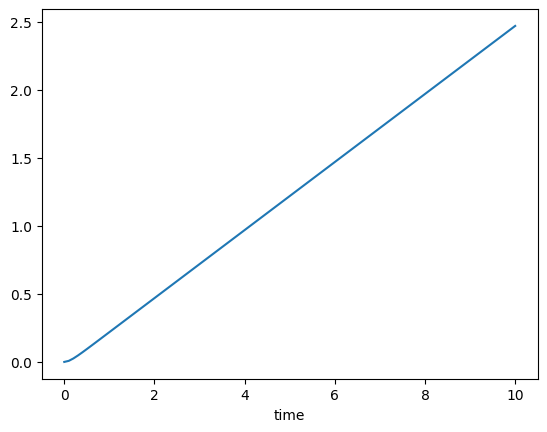

In [8]:
# Plotting
times = np.linspace(0, 10, 100)
_, yt = control.forced_response(G_tf, T=times, U=1)
plt.plot(times, yt)
plt.xlabel("time")

## 5. (5 pts) Simulate in Antimony

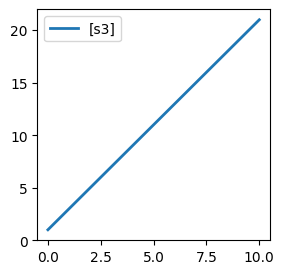

In [9]:
model = """
$s1 -> s2; k1*s1
$s2 -> s1; k2*s2
$s1 -> s3; k3*s1
$u -> s2; k1*u

s1 = 1
s2 = 1
s3 = 1
u = 1
k1 = 1
k2 = 2
k3 = 2
"""
rr = te.loada(model)
rr.simulate(0, 10, 100)
rr.plot(figsize=(3,3))

## 6. (5 pts) Analysis

1. How does the transfer function you derived and simulated in step 3 compare with the simulation results for the Antimony model in step 4?
1. How does DC gain change as $k_1$ increases?
1. Explain why the DC gain of this system is finite whereas the DC gain of the system with $s_3$ as output does not have finite DC gain.


1. They're the same
2. It doesn't change
3. Assuming __"this system"__ means the Antimony one?!, the difference is that our laplace for $s_{3}$ has an integrator $\frac{1}{s}$ which makes it infinite

# Problem 2: System Identification

You will do system identification for the system you chose in the first homework.

## 1. (20 pts) Determine the operating region for you system.

Use ``SISOTransferFunctionBuilder`` to plot a staircase of the control input to your system and the measured output.
Explain why you chose the operating region you did (i.e., the value ranges of
the control input).

In [10]:
# import
import controlSBML as ctl

# model
url = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000507.2?filename=BIOMD0000000507_url.xml"
BioCSBML = ctl.ControlSBML(url, input_names=['species_2'], output_names=['species_1'])

# make builder
model_builder = BioCSBML.makeSISOTransferFunctionBuilder()
model_builder.input_name, model_builder.output_name

('species_2', 'species_1')

### Plotting Function

In [11]:
def plotStaircaseResponse(builder, is_plot=True, **kwargs):
    """
    This function circumvents a bug in SISOTransferFunctionBuilder.plotStairCaseResponse.
    It has the same arguments and return value as the original function.
    """
    plot_result = builder.plotStaircaseResponse(is_plot=False, **kwargs)
    # Plot if requested
    if is_plot:
        times = np.array(plot_result.time_series.index)/1000
        df = pd.DataFrame(plot_result.time_series)
        df.index = times
        if "figsize" in kwargs.keys():
            figsize = kwargs["figsize"]
        else:
            figsize = (10, 10)
        legends = list(df.columns)
        fig, ax = plt.subplots(1, figsize=figsize)
        staircase_column = [c for c in df.columns if "staircase" in c][0]
        staircase_values = df[staircase_column].values
        del df[staircase_column]
        ax.plot(df)
        ax2 = ax.twinx()
        # Plot the staircase
        ax2.plot(times, staircase_values, color="red",
              linestyle="--")
        ax2.set_ylabel(staircase_column, color="red")
        ax.legend(df.columns)
    #
    return plot_result

# TESTS
if False:
    plot_response = plotStaircaseResponse(linear_builder, initial_value=2, final_value=10, num_step=5, figsize=(3,3),
                                        legend_crd=(0.5, 1), end_time=100, is_plot=True)
    assert(isinstance(plot_response.time_series, ctl.Timeseries))
    print("OK!")

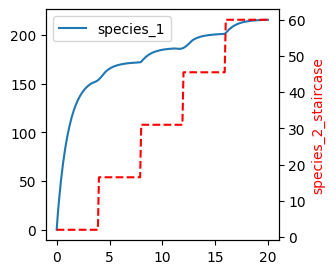

In [12]:
plotStaircaseResponse(model_builder, initial_value=2, final_value=60, num_step=5, figsize=(3,3),
                                    legend_crd=(0.5, 1), end_time=20)

**Comment**
1. You may have wanted a longer time period so that the system settles more before the next step in the staircase.

__Answer__: _Chose Final value of 60 because around Approx. 45 the output begins to match the input step function_

## 2. (20 pts) Find a tranfser function for your system for the operating region.

Use ``SISOTransferFunctionBuilder`` to fit a transfer function for your system.
Justify that the transfer function fits sufficiently well and does not overfit.

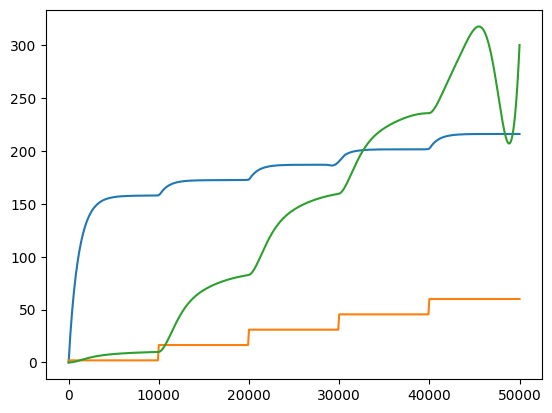

In [13]:


fitter_result = model_builder.fitTransferFunction(4, 6, 
                                                   final_value=60,
                                                   initial_value=2, end_time=50)
#ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))
plt.plot(fitter_result.time_series)

## 3. (10 pts)  Analyze the transfer function.

What is the DC gain? What are the poles? What are the implications for control?

In [14]:
tf = fitter_result.transfer_function
tf

TransferFunction(array([ 0.24921598,  0.00050918, -0.00038927,  0.24976234]), array([0.12276974, 0.11546218, 0.11208014, 0.05781315, 0.18055639,
       0.0469905 ]))

In [15]:
tf.dcgain()

5.315166180140816

In [16]:
tf.poles()

array([-0.8331416 +0.8378522j , -0.8331416 -0.8378522j ,
        0.49994462+0.86620713j,  0.49994462-0.86620713j,
       -0.27408355+0.j        ])

In [17]:
fitter_result.nfev #implication for control?

164